# Triple Influence Ranking Model (TIRM): una medida de influencia de usuarios en Twitter

## 1. Preparación de los datos

In [9]:
#Cargamos los paquetes necesarios.

import pickle
import bson
import pandas as pd
from bson import ObjectId

In [10]:
#Cargamos tanto los usuarios como todas las interacciones.

filename = "usuarios.pickle"
usuarios = pd.read_pickle(filename)
#Guardamos todos los ids de los usuarios de la muestra para limpiar las interacciones
idsMuestra = usuarios["_id"].to_list()

#Cargamos los datos de los tweets, que son todas las interacciones.
filename = "tweets.pickle"
tweets = pd.read_pickle(filename)

#Solo nos quedamos con las interacciones que se hayan realizado entre un par de 
#usuarios cuyos ids hayamos cogido antes.
tweets = tweets[tweets.user_id.isin(idsMuestra)
                & (tweets.in_reply_to_user_id.isin(idsMuestra) | 
                tweets.retweet_or_quote_user_id.isin(idsMuestra))]

In [11]:
#Unimos las columnas del conjuto de datos tweets referentes al usuario al que va dirigida la interacción,
#ya que este dato está dividido en dos columnas dependiendo del tipo de interacción. De esta forma lo tendremos
#mejor organizado.

to_user_id = []

for index, row in tweets.iterrows():
    if row["in_reply_to_user_id"] == None:
        
        to_user_id.append(row["retweet_or_quote_user_id"])
        
    else:
        
        to_user_id.append(row["in_reply_to_user_id"])
        
tweets["to_user_id"] = to_user_id

#Tras esto realizamos el group by, para obtener la informacion deseada de cada usuario.

prueba = tweets.groupby(['user_id', 'to_user_id', 'tweet_type'])['to_user_id'].count().reset_index(name="count")

In [12]:
#Una vez agrupados los datos referentes a las interacciones, vamos a descartar del conjunto de usuarios todos 
#aquellos que no realizen ni reciban ninguna interacción.

aliveUsers = []

for index, row in prueba.iterrows():
    
    if (row['user_id'] in aliveUsers) == False:
        
        aliveUsers.append(row['user_id'])
        
    if (row['to_user_id'] in aliveUsers) == False:
        
        aliveUsers.append(row['to_user_id'])

    
    
usuarios = usuarios[usuarios._id.isin(aliveUsers)]

#Machacamos el conjunto de ids de la muestra de usuarios, para descartar los que no hacen nada.

idsMuestra = usuarios["_id"].to_list()

In [13]:
#Claramente la cantidad de usuarios que estamos estudiando se ve reducida drsticamente cuando eliminamos los 
#que no han realizado ni una interaccion, pero ademas este conjunto deberia reducirse aun mas ya que seguimos
#usando un monton de usuarios que solo producen tweets pero nadie se dirige a ellos.
len(usuarios)

68012

In [14]:
#Creamos un diccionario que relaciona cada usuario con todos los usuarios que alguna vez han creado contenido
#refiriendose a este, y asocia el número de cada tipo que ha realizado.
interacciones = {}

for index, row in prueba.iterrows():
    
    #Si son de tipo originales no los tenemos en cuenta.
    if row["tweet_type"] != "original":
    
        #Comprobamos si para este usuario hemos creado ya su hueco en el diccionario, si no se crea.
        if row["to_user_id"] in interacciones:
        
            if row["user_id"] in interacciones[row["to_user_id"]]:
                
                interacciones[row["to_user_id"]][row["user_id"]][row["tweet_type"]] = row["count"]
        
            else:
                
                interacciones[row["to_user_id"]][row["user_id"]] = {"quote" : 0, "retweet" : 0, "reply" : 0}
                
                interacciones[row["to_user_id"]][row["user_id"]][row["tweet_type"]] = row["count"]
                
        
        else:
        
            interacciones[row["to_user_id"]] = {}
            
            interacciones[row["to_user_id"]][row["user_id"]] = {"quote" : 0, "retweet" : 0, "reply" : 0}
                
            interacciones[row["to_user_id"]][row["user_id"]][row["tweet_type"]] = row["count"]

In [ ]:
interacciones

In [15]:
#Ahora vamos a quedarnos con los conjuntos de seguidores de cada usuario pero de forma que todos los usuarios 
#con los que nos quedemos también estén en la red ya que si no, no nos proporciona nada. Para ello definimos 
#una función que realiza la intersección de dos conjuntos

def intersectionLists(list1, list2):  

    result = list(set(list1).intersection(list2))
    return result

followers = {}

for index, row in usuarios.iterrows():
    
    followers[row["_id"]] = intersectionLists(idsMuestra, row["followers"])
    
idNodos = idsMuestra

## 2. Creación de los diferentes grafos

In [8]:
#Ahora vamos a crear las aristas de cada grafo, para ello definimos un diccionario que contendra todas las aristas
#como clave, y el peso de cada una de ellas como valor.

#GRAFO DE FOCO

aristasGF = {}
beta = 0.7

for user1 in interacciones:
    
    for user2 in interacciones[user1]:
        
        if (interacciones[user1][user2]["reply"] > 0 or interacciones[user1][user2]["retweet"] > 0):
            if user1 != user2:
                arista = "("+str(user1)+","+str(user2)+")"
                aristasGF[arista] = beta *  interacciones[user1][user2]["retweet"] + (1-beta) * interacciones[user1][user2]["reply"]
            
            
#GRAFO DE AUTORIDAD

aristasGA = {}

for user1 in interacciones:
    
    for user2 in interacciones[user1]:
        
        if (interacciones[user1][user2]["quote"] > 0) and user1 != user2:
            
            arista = "("+str(user1)+","+str(user2)+")"
            aristasGA[arista] = interacciones[user1][user2]["quote"]
            
            
#GRAFO DE CENTRALIDAD

aristasGC = {}
gamma = 0.6

for user1 in followers:
    
    for user2 in followers[user1]:
        arista = "("+str(user1)+","+str(user2)+")"
        aristasGC[arista] = gamma * len(followers[user1]) + (1 - gamma) * len(followers[user2])

In [ ]:
#Vamos a guardar los diferentes diccionarios que representan las aristas de cada grafo, junto a la lista de 
#todos los nodos.

import pickle

f = open("aristasGF.pkl","wb")
pickle.dump(aristasGF,f)
f.close()

f = open("aristasGA.pkl","wb")
pickle.dump(aristasGA,f)
f.close()

f = open("aristasGC.pkl","wb")
pickle.dump(aristasGC,f)
f.close()

f = open("idNodos.pkl","wb")
pickle.dump(idNodos,f)
f.close()

## 3. Ejecución del método TIRM

In [9]:
#Una vez llegados a este punto, tenemos todos los pesos de aristas para cada uno de los grafos, luego podemos 
#comenzar a calcular los pesos para cada nodo en cada grafo. 

#Vamos a realizar un paso previo muy importante, este es relacionar cada nodo con sus aristas para cada grafo
#Cada nodo con las aristas que salen de el. De esta forma evitamos repetir el proceso muchas veces. 
#Las claves son los ids de los usuarios pero en string.

def nodoAristas(aristasGrafo):
    
    nodoAristas = {}
    for nodoId in idNodos:
        
        nodoid = str(nodoId)
        nodoAristas[nodoid] = []
        for arista in aristasGrafo:
            
            if ("("+nodoid) in arista:
                
                nodoAristas[nodoid].append(arista)
                
    return nodoAristas

nodoAristasGF = nodoAristas(aristasGF)
nodoAristasGA = nodoAristas(aristasGA)
nodoAristasGC = nodoAristas(aristasGC)

#Pasamos ahora al cálculo del peso NIWT:
#No necesitamos introducir nodos a la función ya que los tres grafos trabajan con el mismo conjunto.
def NIWT(aristasGrafo, alpha, nodoA): 
    
    NIWT = {}
    for nodoId in idNodos:
        
        nodoid = str(nodoId)
        pesosAristas = 0
        
        for key in nodoA[nodoid]:
            
            pesosAristas = pesosAristas + aristasGrafo[key]
        
        NIWT[nodoid] = alpha * len(nodoA[nodoid]) + (1 - alpha) * pesosAristas

    return NIWT


NIWTfoco = NIWT(aristasGF, 0.5, nodoAristasGF)
NIWTautoridad = NIWT(aristasGA, 0.5, nodoAristasGA)
NIWTcentralidad = NIWT(aristasGC, 0.5, nodoAristasGC)

In [10]:
#Ahora pasamos al cálculo de los pesos en la fase de poda del grafo, NPWT.
#El codigo es exactamente el pseudocodigo del trabajo pero pasado a python.

def NPWT(aristasGrafo, alpha, niwt, nodoA):
    
    NPWT = {}
    for nodo1 in idNodos:
        
        nodo1id = str(nodo1)
        pesoGrafo = 0
        
        for nodo2 in idNodos:
            
            pesosAristas = 0
            nodo2id = str(nodo2)
            
            if nodo2 != nodo1:
                
                for arista in nodoA[nodo2id]:
                    
                    nodo3id = ((arista.split(","))[1])[:-1]
                    
                    pesosAristas = pesosAristas + aristasGrafo[arista] + niwt[nodo3id]
                
                pesoGrafo = pesoGrafo + alpha * len(nodoA[nodo2id]) + (1 - alpha) * pesosAristas
        
        NPWT[nodo1id] = pesoGrafo
    
    return NPWT 

NPWTfoco = NPWT(aristasGF, 0.5, NIWTfoco, nodoAristasGF)
NPWTautoridad = NPWT(aristasGA, 0.5, NIWTautoridad, nodoAristasGA)
NPWTcentralidad = NPWT(aristasGC, 0.5, NIWTcentralidad, nodoAristasGC)

In [19]:
#También guardamos estos datos de cada grafo por si los necesitaramos más adelante.

f = open("NPWTfoco.pkl","wb")
pickle.dump(NPWTfoco,f)
f.close()

f = open("NPWTautoridad.pkl","wb")
pickle.dump(NPWTautoridad,f)
f.close()

f = open("NPWTcentralidad.pkl","wb")
pickle.dump(NPWTcentralidad,f)
f.close()

### 3.1 Cálculo del valor TI

In [11]:
#Una vez tenemos los resultados de cada nodo, los ordenamos en capas

def capas(NPWT):
    
    capas = {}
    
    for nodo in NPWT:
        
        if (NPWT[nodo] in capas):
            
            capas[NPWT[nodo]].append(nodo)
            
        else:
            
            capas[NPWT[nodo]] = [nodo]
            
    return capas

capasFoco = capas(NPWTfoco)
capasAutoridad = capas(NPWTautoridad)
capasCentralidad = capas(NPWTcentralidad)

#Guardamos la cantidad de capas de cada una de las listas para poder cálcular nuestra medida

ncf = len(capasFoco)
nca = len(capasAutoridad)
ncc = len(capasCentralidad)

In [12]:
#Faltaría ordenar el diccionario por el valor de sus key, y luego cambiar el nombre de las key por 1,2,3..
#lo que serían las capas respectivas. DESCENDENTE


#Para el grafo de foco
puntuaciones = list(capasFoco.keys())
puntuaciones.sort(reverse = True)

capasFocoOrd = {}
contador = 0

for key in puntuaciones:
    
    capasFocoOrd[contador] = capasFoco[key]
    contador = contador + 1

    
    
    
#Para el grafo de autoridad
puntuaciones = list(capasAutoridad.keys())
puntuaciones.sort(reverse = True)

capasAutoridadOrd = {}
contador = 0

for key in puntuaciones:
    
    capasAutoridadOrd[contador] = capasAutoridad[key]
    contador = contador + 1

    
    
    
#Para el grafo de centralidad
puntuaciones = list(capasCentralidad.keys())
puntuaciones.sort(reverse = True)

capasCentralidadOrd = {}
contador = 0

for key in puntuaciones:
    
    capasCentralidadOrd[contador] = capasCentralidad[key]
    contador = contador + 1

In [13]:
#Tras esto tendremos asociados cada uno de los usuarios a la capa en la que se encuentran para cada
#grafo

def userCapa(capasOrd):
    
    userCapa = {}
    
    for capa in capasOrd:
        for user in capasOrd[capa]:
            
            userCapa[user] = capa
    
    return userCapa

userCapaFoco = userCapa(capasFocoOrd)
userCapaAutoridad = userCapa(capasAutoridadOrd)
userCapaCentralidad = userCapa(capasCentralidadOrd)

In [14]:
#Calculamos la medida TIRM finalmente, con la siguiente función 

import math

def TI(userCapa1, userCapa2, userCapa3, nc1, nc2, nc3):
    
    TI = {}
    
    numberUsers = len(userCapa1)
    digitos = len(str(numberUsers))
    h1 = digitos/2
    h = round(digitos/2)
    if h1 > h:
        h + 1
        
    for user in userCapa1:
        if (userCapa1[user] + userCapa2[user] + userCapa3[user]) != 0:
            TI[user] = ( (math.log(userCapa1[user] + userCapa2[user] + userCapa3[user])) / math.log(nc1 + nc2 + nc3) )**(h)
        else:
            TI[user] = 0
    
    return TI
    

TIFinal = TI(userCapaFoco, userCapaAutoridad, userCapaCentralidad, ncf, nca, ncc)

In [30]:
#Comprobamos que todo ha salido como esperabamos, ya que no nos hemos dejado ningun usuario por el camino
len(TIFinal)

68012

In [40]:
#Finalmente, con las puntuaciones conseguidas vamos a ordenarlos otra vez, lo que ya será la puntuación final.
TIFGrupos = {}

for user in TIFinal:
    
    if TIFinal[user] in TIFGrupos:
        TIFGrupos[TIFinal[user]].append(user)
    else:
        TIFGrupos[TIFinal[user]] = [user]

puntuaciones = list(TIFGrupos.keys())
puntuaciones.sort(reverse = True)

puntuacionesOrd = {}

for key in puntuaciones:
    
    puntuacionesOrd[key] = TIFGrupos[key]

In [41]:
#Vamos a comprobar la separación realizada mediante el Average Shell Load ASL
ALS = 0
for capa in puntuacionesOrd:
    
    ALS = ALS + len(puntuacionesOrd[capa])
    
ALS = ALS/len(puntuacionesOrd)
ALS

3.1878134520740566

In [4]:
#A diferencia de los resultados con el metodo IRM por separado, esta vez conseguimos una menor separacion.
#Obviamente esto se debe a los escasos datos con los que hemos formado los grafos de foco y autoridad.

In [69]:
#Que se obtenga finalmente esa puntuacion me hace darme cuenta de que siguen habiendo miles de usuarios
#que no reciben ningun tipo de interaccion, solo la producen ellos.

#Podemos ver que el total de capas de las que disponemos serian
len(puntuacionesOrd)

21335

In [43]:
#Y en la primera capa nos encontramos con un monton de usuarios 
len(puntuacionesOrd[0])

13778

In [17]:
#Guardamos el resultado final que nos ordena todos los nodos según su puntuación final.

f = open("puntuacionesOrd.pkl","wb")
pickle.dump(puntuacionesOrd,f)
f.close()

## 4. Estudio de los resultados obtenidos

### 4.1 Obtención de los diferentes grupos

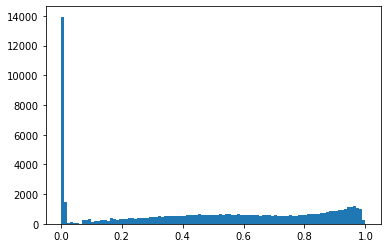

In [164]:
#Vamos a mostrar un histograma con las puntuaciones que hemos establecido para cada usuario, a ver donde se 
#concentran mas usuarios.
dataforHist = []
for user in TIFinal:
    dataforHist.append(TIFinal[user])

import matplotlib.pyplot as plt

plt.hist(dataforHist, bins = 100)
plt.show()

In [8]:
#Podemos observar claramente como la mayoria de personas, inmensa mayoria, no son siquiera algo influyentes
#Establecemos el percentil del 95%, el del 75% y el del 50% para crear los cuatro grupos con los que vamos a
#trabajar

umbral95 = 0.05
umbral75 = 0.25
umbral50 = 0.5


totalUser = 68012
users95 = []
users75 = []
users50 = []
users0 = []
contador = 0

for puntuacion in puntuacionesOrd:
    for user in puntuacionesOrd[puntuacion]:
        p = contador/totalUser
        
        if p < umbral95:
            
            users95.append(user)
            contador = contador + 1
            
        elif p < umbral75:
            
            users75.append(user)
            contador = contador + 1
        
        elif p < umbral50:
            
            users50.append(user)
            contador = contador + 1
            
        else:
            
            users0.append(user)
            contador = contador + 1
            
            

In [16]:
len(users0)

34006

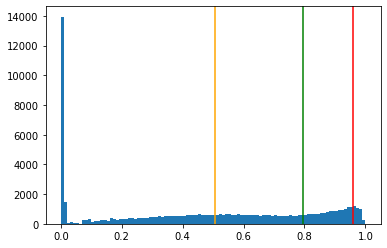

In [193]:
#Vamos a mostrar un histograma con las puntuaciones que hemos establecido para cada usuario, a ver donde se 
#concentran màs usuarios.
dataforHist = []
for user in TIFinal:
    dataforHist.append(TIFinal[user])

import matplotlib.pyplot as plt

plt.hist(dataforHist, bins = 100)
plt.axvline(x=TIFinal[users95[-1]], color = "red")
plt.axvline(x=TIFinal[users75[-1]], color = "green")
plt.axvline(x=TIFinal[users50[-1]], color = "orange")

plt.show()

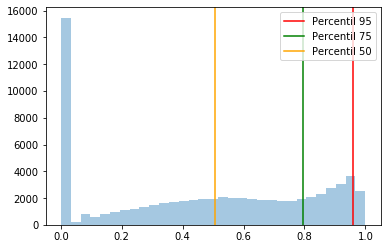

In [209]:
#Faltaria comprobar que efectivamente existen diferencias palpables dentro de los diferentes grupos.
import seaborn as sns
sns.distplot(dataforHist, kde = False)
plt.axvline(x=TIFinal[users95[-1]], color = "red", label = "Percentil 95")
plt.axvline(x=TIFinal[users75[-1]], color = "green", label = "Percentil 75")
plt.axvline(x=TIFinal[users50[-1]], color = "orange", label = "Percentil 50")
plt.legend(loc="upper right") 
plt.savefig('distribucion-percent.png')

### 4.2 Comparación de los diferentes grupos según los parámetros de los usuarios que los componen

In [27]:
#Buscando caracterizar de una forma mas clara todos y cada uno de los usuarios, vamos a comparar la media de 
#cada uno de los atributos usados para crear el metodo dependiendo del grupo
#Estos parametros son retweets, replies, quotes y number of followers

In [38]:
#Comenzamos creando el diccionario que va a contener la media del numero de retweets para cada grupo

mediaRetweets = {"Grupo A" : 0, "Grupo B" : 0, "Grupo C" : 0, "Grupo D" : 0}
contadorA = 0
contadorB = 0
contadorC = 0
contadorD = 0

contador = 0

#Lo que hacemos es coger la cantidad de retweets para todo usuario que haya producido alguno y lo metemos dentro
#del contador del grupo que pertenezca, luego dividimos por el numero total de usuarios de ese grupo

for user1 in interacciones:
    
    contador = 0
    user1str = str(user1)
    
    for user2 in interacciones[user1]:
        
        contador = contador + interacciones[user1][user2]["retweet"]
        
    if user1str in users95:
        
        contadorA = contadorA + contador
        
    elif user1str in users75:
        
        contadorB = contadorB + contador
        
    elif user1str in users50:
        
        contadorC = contadorC + contador
        
    else:
        
        contadorD = contadorD + contador


#Guardamos todos los valores, cada uno asociado a su respectivo grupo
mediaRetweets["Grupo A"] = contadorA/len(users95)
mediaRetweets["Grupo B"] = contadorB/len(users75)
mediaRetweets["Grupo C"] = contadorC/len(users50)
mediaRetweets["Grupo D"] = contadorD/len(users0)

In [39]:
mediaRetweets

{'Grupo A': 23.58894442810938,
 'Grupo B': 2.1393177473900895,
 'Grupo C': 2.30465212021408,
 'Grupo D': 0.29250720461095103}

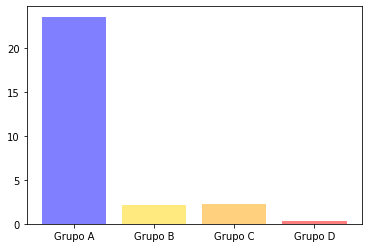

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

x = []
y = []
for grupo in mediaRetweets:
    x.append(grupo)
    y.append(mediaRetweets[grupo])
    
plt.bar(x, y, align='center', alpha=0.5, color=("blue", "gold", "orange", "red"))
#plt.ylabel('Media punt. IRM')
#plt.title('Grafo de foco')

axes = plt.gca()

plt.savefig('comp-retweets.png')

In [36]:
#Mismo procedimiento, pero esta vez para el numero total de menciones

mediaQuotes = {"Grupo A" : 0, "Grupo B" : 0, "Grupo C" : 0, "Grupo D" : 0}
contadorA = 0
contadorB = 0
contadorC = 0
contadorD = 0

contador = 0

for user1 in interacciones:
    
    contador = 0
    user1str = str(user1)
    
    for user2 in interacciones[user1]:
        
        contador = contador + interacciones[user1][user2]["quote"]
        
    if user1str in users95:
        
        contadorA = contadorA + contador
        
    elif user1str in users75:
        
        contadorB = contadorB + contador
        
    elif user1str in users50:
        
        contadorC = contadorC + contador
        
    else:
        
        contadorD = contadorD + contador

            
mediaQuotes["Grupo A"] = contadorA/len(users95)
mediaQuotes["Grupo B"] = contadorB/len(users75)
mediaQuotes["Grupo C"] = contadorC/len(users50)
mediaQuotes["Grupo D"] = contadorD/len(users0)

In [37]:
mediaQuotes

{'Grupo A': 0.1796530432225816,
 'Grupo B': 0.01485075724158212,
 'Grupo C': 0.006234193965770746,
 'Grupo D': 0.0035287890372287245}

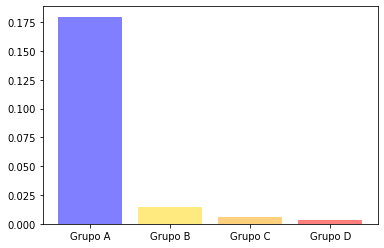

In [42]:
x = []
y = []
for grupo in mediaQuotes:
    x.append(grupo)
    y.append(mediaQuotes[grupo])
    
plt.bar(x, y, align='center', alpha=0.5, color=("blue", "gold", "orange", "red"))
#plt.ylabel('Media punt. IRM')
#plt.title('Grafo de foco')

axes = plt.gca()

plt.savefig('comp-quotes.png')

In [34]:
#Ahora con el numero total de comentarios

mediaReplies = {"Grupo A" : 0, "Grupo B" : 0, "Grupo C" : 0, "Grupo D" : 0}
contadorA = 0
contadorB = 0
contadorC = 0
contadorD = 0

contador = 0

for user1 in interacciones:
    
    contador = 0
    user1str = str(user1)
    
    for user2 in interacciones[user1]:
        
        contador = contador + interacciones[user1][user2]["reply"]
        
    if user1str in users95:
        
        contadorA = contadorA + contador
        
    elif user1str in users75:
        
        contadorB = contadorB + contador
        
    elif user1str in users50:
        
        contadorC = contadorC + contador
        
    else:
        
        contadorD = contadorD + contador

            
mediaReplies["Grupo A"] = contadorA/len(users95)
mediaReplies["Grupo B"] = contadorB/len(users75)
mediaReplies["Grupo C"] = contadorC/len(users50)
mediaReplies["Grupo D"] = contadorD/len(users0)

In [35]:
mediaReplies

{'Grupo A': 0.7474272272860923,
 'Grupo B': 0.07344508160564622,
 'Grupo C': 0.02329000764570958,
 'Grupo D': 0.0204669764159266}

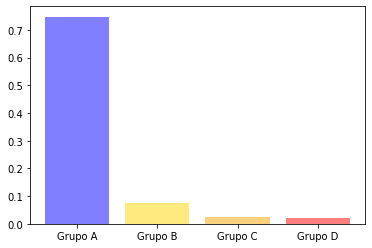

In [44]:
x = []
y = []
for grupo in mediaReplies:
    x.append(grupo)
    y.append(mediaReplies[grupo])
    
plt.bar(x, y, align='center', alpha=0.5, color=("blue", "gold", "orange", "red"))
#plt.ylabel('Media punt. IRM')
#plt.title('Grafo de foco')

axes = plt.gca()

plt.savefig('comp-replies.png')

In [32]:
#Ahora con el numero total de seguidores de cada usuario

mediaFollowers = {"Grupo A" : 0, "Grupo B" : 0, "Grupo C" : 0, "Grupo D" : 0}
contadorA = 0
contadorB = 0
contadorC = 0
contadorD = 0


for user1 in followers:
    
    user1str = str(user1)
        
    if user1str in users95:
        
        contadorA = contadorA + len(followers[user1])
        
    elif user1str in users75:
        
        contadorB = contadorB + len(followers[user1])
        
    elif user1str in users50:
        
        contadorC = contadorC + len(followers[user1])
        
    else:
        
        contadorD = contadorD + len(followers[user1])

            
mediaFollowers["Grupo A"] = contadorA/len(users95)
mediaFollowers["Grupo B"] = contadorB/len(users75)
mediaFollowers["Grupo C"] = contadorC/len(users50)
mediaFollowers["Grupo D"] = contadorD/len(users0)

In [33]:
mediaFollowers

{'Grupo A': 61.496324610408706,
 'Grupo B': 10.48191442434936,
 'Grupo C': 5.848203258248544,
 'Grupo D': 1.2810092336646475}

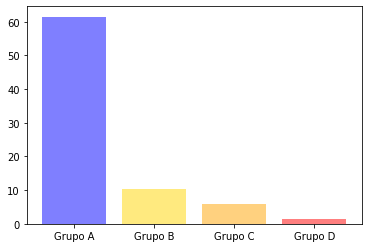

In [45]:
x = []
y = []
for grupo in mediaFollowers:
    x.append(grupo)
    y.append(mediaFollowers[grupo])
    
plt.bar(x, y, align='center', alpha=0.5, color=("blue", "gold", "orange", "red"))
#plt.ylabel('Media punt. IRM')
#plt.title('Grafo de foco')

axes = plt.gca()

plt.savefig('comp-followers.png')

In [274]:
#Buscando caracterizar los usuarios aun mas dependiendo del grupo al que pertenecen, vamos a comparar la media
#de las puntuaciones NPWT de los grupos A,B,C,D.

NPWTfocoMedias = { "Grupo A" : 0, "Grupo B" : 0, "Grupo C" : 0, "Grupo D" : 0}

num = 0
denom = len(users95)
for user in users95:
    num = num + NPWTfoco[user]
    
NPWTfocoMedias["Grupo A"] = num/denom

num = 0
denom = len(users75)
for user in users75:
    num = num + NPWTfoco[user]
    
NPWTfocoMedias["Grupo B"] = num/denom

num = 0
denom = len(users50)
for user in users50:
    num = num + NPWTfoco[user]
    
NPWTfocoMedias["Grupo C"] = num/denom

num = 0
denom = len(users0)
for user in users0:
    num = num + NPWTfoco[user]
    
NPWTfocoMedias["Grupo D"] = num/denom


In [275]:
NPWTfocoMedias

{'Grupo A': 321846.91308436095,
 'Grupo B': 321901.8928392815,
 'Grupo C': 321902.7063929818,
 'Grupo D': 321905.4828566893}

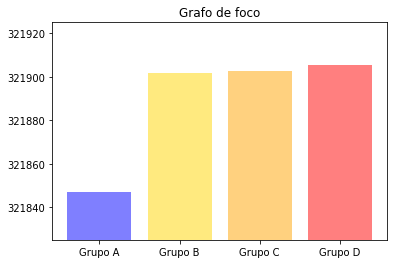

In [276]:
x = []
y = []
for grupo in NPWTfocoMedias:
    x.append(grupo)
    y.append(NPWTfocoMedias[grupo])
    
plt.bar(x, y, align='center', alpha=0.5, color=("blue", "gold", "orange", "red"))
#plt.ylabel('Media punt. IRM')
plt.title('Grafo de foco')

axes = plt.gca()
axes.set_ylim([321825,321925])

plt.savefig('puntuaciones-grafF.png')

In [277]:
NPWTautoridadMedias = { "Grupo A" : 0, "Grupo B" : 0, "Grupo C" : 0, "Grupo D" : 0}

num = 0
denom = len(users95)
for user in users95:
    num = num + NPWTautoridad[user]
    
NPWTautoridadMedias["Grupo A"] = num/denom

num = 0
denom = len(users75)
for user in users75:
    num = num + NPWTautoridad[user]
    
NPWTautoridadMedias["Grupo B"] = num/denom

num = 0
denom = len(users50)
for user in users50:
    num = num + NPWTautoridad[user]
    
NPWTautoridadMedias["Grupo C"] = num/denom

num = 0
denom = len(users0)
for user in users0:
    num = num + NPWTautoridad[user]
    
NPWTautoridadMedias["Grupo D"] = num/denom

NPWTautoridadMedias

{'Grupo A': 717.5977653631285,
 'Grupo B': 717.7418394353772,
 'Grupo C': 717.7475004410986,
 'Grupo D': 717.7486325942481}

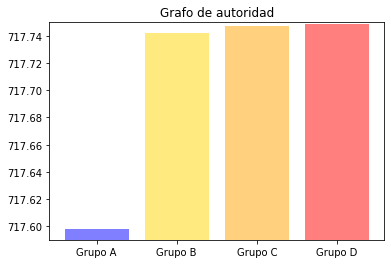

In [278]:
x = []
y = []
for grupo in NPWTautoridadMedias:
    x.append(grupo)
    y.append(NPWTautoridadMedias[grupo])
    
plt.bar(x, y, align='center', alpha=0.5, color=("blue", "gold", "orange", "red"))
#plt.ylabel('Media punt. IRM')
plt.title('Grafo de autoridad')

axes = plt.gca()
axes.set_ylim([717.59,717.75])

plt.savefig('puntuaciones-grafA.png')

In [279]:
NPWTcentralidadMedias = { "Grupo A" : 0, "Grupo B" : 0, "Grupo C" : 0, "Grupo D" : 0}

num = 0
denom = len(users95)
for user in users95:
    num = num + NPWTcentralidad[user]
    
NPWTcentralidadMedias["Grupo A"] = num/denom

num = 0
denom = len(users75)
for user in users75:
    num = num + NPWTcentralidad[user]
    
NPWTcentralidadMedias["Grupo B"] = num/denom

num = 0
denom = len(users50)
for user in users50:
    num = num + NPWTcentralidad[user]
    
NPWTcentralidadMedias["Grupo C"] = num/denom

num = 0
denom = len(users0)
for user in users0:
    num = num + NPWTcentralidad[user]
    
NPWTcentralidadMedias["Grupo D"] = num/denom

NPWTcentralidadMedias

{'Grupo A': 2435291054.676032,
 'Grupo B': 2435867471.3761644,
 'Grupo C': 2435894616.4507575,
 'Grupo D': 2435894983.0072827}

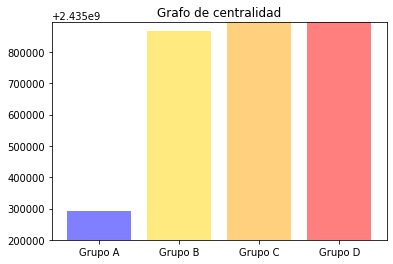

In [280]:
x = []
y = []
for grupo in NPWTcentralidadMedias:
    x.append(grupo)
    y.append(NPWTcentralidadMedias[grupo])
    
plt.bar(x, y, align='center', alpha=0.5, color=("blue", "gold", "orange", "red"))
#plt.ylabel('Media punt. IRM')
plt.title('Grafo de centralidad')

axes = plt.gca()
axes.set_ylim([2435200000,2435895000])

plt.savefig('puntuaciones-grafC.png')

### 4.3 Estudio de los posibles bots

In [93]:
#Ahora vamos a comprobar si alguno de los usuarios que hemos cogido son bots, tomamos como umbral para que sean bots
#el valor 0.691, basándonos en el estudio que se detalla en el trabajo.

#Cargamos los datos de los usuarios, y tomamos solo un trozo de los datos para no guardarlo todo.

filename = "usuarios.pickle"
idsProbBot = pd.read_pickle(filename)
#Todos los ids de los usuarios de la muestra

idsProbBot = idsProbBot[["_id", "scores_scores_universal"]]

posBots = {}

for index, row in idsProbBot.iterrows():
    
    if row["scores_scores_universal"] >= 0.691:
        
        posBots[row["_id"]] = row["scores_scores_universal"]
        
for user in posBots:
    if user in TIFinal:
    
        posBots[user]["TI"] = TIFinal[user]

In [247]:
len(posBots)

37332

In [251]:
#Volvemos a guardar los ids de cada bot, pero esta vez en formato str
posBOTS = []
for user in posBots:
    posBOTS.append(str(user))

In [266]:
#Guardamos ahora toda la informacion relevate de cada uno de los usuarios que pueden ser bots

infBOTS = {}

contador = 0 
for puntuacion in puntuacionesOrd:
    for user in puntuacionesOrd[puntuacion]:
        contador = contador + 1
        
        if user in posBOTS:
            infBOTS[user] = {"TIRM" : puntuacion, "pos" : contador, "Universal Score" : 0}
        

for index, row in idsProbBot.iterrows():
    
    if row["scores_scores_universal"] >= 0.691:
        if str(row["_id"]) in TIFinal:
        
            infBOTS[str(row["_id"])]["Universal Score"] = row["scores_scores_universal"]        

In [267]:
#De todos los usuarios que pueden ser considerados bots, los repartimos en los grupos a los que pertenecen

a = 0
b = 0 
c = 0
d = 0

for user in infBOTS:
    
    if user in users95:
        infBOTS[user]["Grupo"] = "A"
        a = a + 1
        
    elif user in users75:
        infBOTS[user]["Grupo"] = "B"
        b = b + 1
        
    elif user in users50:
        infBOTS[user]["Grupo"] = "C"
        c = c + 1
    
    else:
        infBOTS[user]["Grupo"] = "D"
        d = d + 1

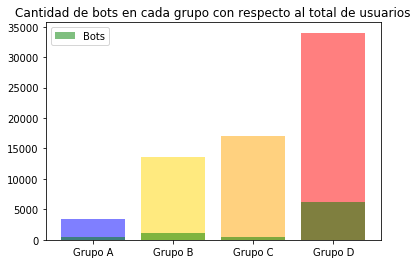

In [288]:
#Podemos observar de forma grafica la cantidad de bots que hay dentro de cada grupo

x = []
y1 = [a,b,c,d]
y = [len(users95), len(users75), len(users50), len(users0)]

for grupo in NPWTfocoMedias:
    x.append(grupo)
    
plt.bar(x, y, align='center', alpha=0.5, color=("blue", "gold", "orange", "red"))
plt.bar(x, y1, align='center', alpha=0.5, color=("green", "green", "green", "green"), label = "Bots")

#plt.ylabel('Media punt. IRM')
plt.title('Cantidad de bots en cada grupo con respecto al total de usuarios')

axes = plt.gca()

plt.legend()

plt.savefig('users-bots.png')

### Anexo: Creación de los archivos para introducir dentro de gephi

In [301]:
#Vamos a crear los archivos csv para introducir dentro del programa gephi

import csv

#Cargamos todos los ids de los usuarios que estamos usando, los relacionamos con sus medidas
#filename = "idNodos.pkl"
#idNodos = pd.read_pickle(filename)

with open("nodes.csv", "w", newline="") as f:
    thewriter = csv.writer(f)
    
    #La primera fila será el nombre de las diferentes columnas.
    thewriter.writerow(["ID", "NPWTfoco", "NPWTautoridad", "NPWTcentralidad", "TI", "Grupo", "Bot"])
    
    #Para cada nodo guardamos los tres valores de las columnas
    for user in idNodos:
        idstr = str(user)
        if idstr in users95:
            
            if idstr in infBOTS:
            
                thewriter.writerow([idstr, NPWTfoco[idstr], NPWTautoridad[idstr], NPWTcentralidad[idstr], TIFinal[idstr], "A", "Yes"])
                
            else:
                
                thewriter.writerow([idstr, NPWTfoco[idstr], NPWTautoridad[idstr], NPWTcentralidad[idstr], TIFinal[idstr], "A", "No"])
                
            
        elif idstr in users75: 
            
            if idstr in infBOTS:
            
                thewriter.writerow([idstr, NPWTfoco[idstr], NPWTautoridad[idstr], NPWTcentralidad[idstr], TIFinal[idstr], "B", "Yes"])
        
            else:
                
                thewriter.writerow([idstr, NPWTfoco[idstr], NPWTautoridad[idstr], NPWTcentralidad[idstr], TIFinal[idstr], "B", "No"])

        elif idstr in users50:
            
            if idstr in infBOTS:
            
                thewriter.writerow([idstr, NPWTfoco[idstr], NPWTautoridad[idstr], NPWTcentralidad[idstr], TIFinal[idstr], "C", "Yes"])
            
            else:

                thewriter.writerow([idstr, NPWTfoco[idstr], NPWTautoridad[idstr], NPWTcentralidad[idstr], TIFinal[idstr], "C", "No"])
    
                
        else:
            
            if idstr in infBOTS:
            
                thewriter.writerow([idstr, NPWTfoco[idstr], NPWTautoridad[idstr], NPWTcentralidad[idstr], TIFinal[idstr], "D", "Yes"])

            else:
                
                thewriter.writerow([idstr, NPWTfoco[idstr], NPWTautoridad[idstr], NPWTcentralidad[idstr], TIFinal[idstr], "D", "No"])
                
            
            

In [99]:
#Vamos a crear ahora el archivo txt referente a las aristas
import csv

with open("edgesFoco.csv", "w", newline="") as f:
    thewriter = csv.writer(f)
    
    #La primera fila será el nombre de las diferentes columnas.
    thewriter.writerow(["Source", "Target", "Type", "Weight"])
    
    #Para cada nodo guardamos los tres valores de las columnas
    for edge in aristasGF:
        e = edge.split(",")
        source = e[0][1:]
        target = e[1][:-1]
        thewriter.writerow([source, target, "Directed", aristasGF[edge]])

In [100]:
with open("edgesAutoridad.csv", "w", newline="") as f:
    thewriter = csv.writer(f)
    
    #La primera fila será el nombre de las diferentes columnas.
    thewriter.writerow(["Source", "Target", "Type", "Weight"])
    
    #Para cada nodo guardamos los tres valores de las columnas
    for edge in aristasGA:
        e = edge.split(",")
        source = e[0][1:]
        target = e[1][:-1]
        thewriter.writerow([source, target, "Directed", aristasGA[edge]])

In [101]:
with open("edgesCentralidad.csv", "w", newline="") as f:
    thewriter = csv.writer(f)
    
    #La primera fila será el nombre de las diferentes columnas.
    thewriter.writerow(["Source", "Target", "Type", "Weight"])
    
    #Para cada nodo guardamos los tres valores de las columnas
    for edge in aristasGC:
        e = edge.split(",")
        source = e[0][1:]
        target = e[1][:-1]
        thewriter.writerow([source, target, "Directed", aristasGC[edge]])

### 4.4 Estudio de los 20 usuarios más influyentes según el nuevo método TIRM

In [ ]:
#Vamos a tomar los primeros 20 usuarios en el top
#vamos a estudiar las características de estos.


#Veinte primeros
veinPrim = []

for puntuacion in puntuacionesOrd:
        
    for user in puntuacionesOrd[puntuacion]:
        
        if len(veinPrim) < 20:
            
            veinPrim.append(user)
            
          
        else:
            
            break

In [126]:
#Estos serian los 20 primeros usuarios encuanto a TIRM
veinPrim

['000000000000000107153756',
 '000000000000001361984828',
 '000000000000000202372417',
 '000000933309177623121921',
 '000000000000000125407623',
 '000000000000000301403189',
 '000000000000000121385551',
 '000000000000003346916993',
 '000000000000000200194757',
 '000000000000000018097083',
 '000000000000000015133318',
 '000000000000000402219133',
 '000000000000000280148714',
 '000000000000000149064381',
 '000000000000000040900410',
 '000000000000002809058993',
 '000000000000002299875572',
 '000000000000000331008858',
 '000000000000000093929450',
 '000000000000000003511961']

In [141]:
userPuestos = {}
contador = 0
for user in veinPrim:
    contador = contador + 1
    userPuestos[user] = {"TIRM":contador, "foco":-userCapaFoco[user]+ncf, "autoridad":-userCapaAutoridad[user]+nca, "centralidad":-userCapaCentralidad[user]+ncc}
    

In [142]:
userPuestos

{'000000000000000107153756': {'TIRM': 1,
  'foco': 5,
  'autoridad': 8,
  'centralidad': 1},
 '000000000000001361984828': {'TIRM': 2,
  'foco': 13,
  'autoridad': 2,
  'centralidad': 7},
 '000000000000000202372417': {'TIRM': 3,
  'foco': 14,
  'autoridad': 10,
  'centralidad': 2},
 '000000933309177623121921': {'TIRM': 4,
  'foco': 18,
  'autoridad': 9,
  'centralidad': 4},
 '000000000000000125407623': {'TIRM': 5,
  'foco': 9,
  'autoridad': 20,
  'centralidad': 12},
 '000000000000000301403189': {'TIRM': 6,
  'foco': 12,
  'autoridad': 22,
  'centralidad': 17},
 '000000000000000121385551': {'TIRM': 7,
  'foco': 22,
  'autoridad': 1,
  'centralidad': 34},
 '000000000000003346916993': {'TIRM': 8,
  'foco': 39,
  'autoridad': 12,
  'centralidad': 8},
 '000000000000000200194757': {'TIRM': 9,
  'foco': 54,
  'autoridad': 5,
  'centralidad': 5},
 '000000000000000018097083': {'TIRM': 10,
  'foco': 26,
  'autoridad': 25,
  'centralidad': 18},
 '000000000000000015133318': {'TIRM': 11,
  'foco': 

In [140]:
#Para el grafo de centralidad
puntuaciones = list(capasCentralidad.keys())
puntuaciones.sort(reverse = False)

capasCentralidadOrd = {}
contador = 0

for key in puntuaciones:
    
    capasCentralidadOrd[contador] = capasCentralidad[key]
    contador = contador + 1
    
capasCentralidadOrd

{0: ['000000000000000107153756'],
 1: ['000000000000000202372417'],
 2: ['000000000000000074205573'],
 3: ['000000933309177623121921'],
 4: ['000000000000000200194757'],
 5: ['000000000000000197863865'],
 6: ['000000000000001361984828'],
 7: ['000000000000003346916993'],
 8: ['000000000000000158313996'],
 9: ['000000000000000064223584'],
 10: ['000000000000000447260411'],
 11: ['000000000000000125407623'],
 12: ['000000000000000040900410'],
 13: ['000000000000000015133318'],
 14: ['000000000000000602263392'],
 15: ['000000000000000402219133'],
 16: ['000000000000000301403189'],
 17: ['000000000000000018097083'],
 18: ['000000000000000331008858'],
 19: ['000000000000000520609496'],
 20: ['000000000000000409256468'],
 21: ['000000000000000222269705'],
 22: ['000000000000000277018118'],
 23: ['000000842106329347039232'],
 24: ['000000000000000003511961'],
 25: ['000000000000000378525757'],
 26: ['000000000000002809058993'],
 27: ['000000000000000022473944'],
 28: ['00000000000000028014871